In [1]:
import pandas as pd
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
from sklearn.metrics import r2_score

def mse_cv(model, X, y):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    #rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    mse = (-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))/1000000
    
    return(mse)

def r2_score_cv(model, X, y):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    #rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    r2_score = (cross_val_score(model, X, y, scoring="r2", cv = kf))
    
    return(r2_score)

In [3]:
X_data = pd.read_csv('./Input_Marcellus_WL_KrigingScenario1.csv', header=None)
Y_data = pd.read_csv('./Output_Marcellus.csv', header=None)

# 기본 데이터 사용

In [4]:
X_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39.359,-80.759,7200,16200,1160,1135,2,2,-1,0,0,0,226.794,2.39378,105.9520
1,39.475,-80.739,7787,13395,1146,1125,0,1,3,0,0,0,212.501,2.39016,94.6122
2,39.414,-80.878,6597,17695,1173,1160,2,1,-1,0,0,0,240.030,2.33778,118.1520
3,39.873,-80.692,6562,13679,1292,1262,0,1,3,0,2,0,248.757,2.44986,105.7200
4,39.432,-80.862,6473,15043,1056,1035,2,2,-1,0,0,0,237.220,2.34264,115.1490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9916,41.133,-78.473,7062,12365,2230,2215,1,-1,-1,0,0,0,218.192,2.59755,111.7690
9917,41.866,-75.682,6302,12035,1382,1356,0,3,10,0,0,0,270.579,2.51832,242.6610
9918,41.739,-75.710,7202,13776,1319,1292,2,4,5,0,0,0,257.898,2.53448,186.4050
9919,41.772,-75.676,7171,15192,1532,1514,0,4,5,0,0,0,271.100,2.51814,228.6070


In [5]:
X_data.columns = ['Latitude_BH',
                  'Longitude_BH',
                  'TVD_FT',
                  'MD_FT',
                  'ElevationKB_FT',
                  'ElevationGL_FT', #여기까지 Location
                  'WellDirection',
                  'FirstProdYear',
                  'Field',
                  'Formation',
                  'ENVFracJobType',
                  'ENVProppantType', # 여기까지 Dr. Lim
                  'GR',
                  'RES',
                  'RHOB',
                 ]

In [6]:
Y_data

,0,1
0,4484200.0,11195.0
1,3252300.0,23533.0
2,5330500.0,40126.0
3,2065800.0,73470.0
4,4457500.0,12672.0
...,...,...
9916,635570.0,0.0
9917,5314900.0,0.0
9918,5980200.0,0.0
9919,8275900.0,0.0


In [7]:
Y_data_36Gas = Y_data[0]

In [8]:
X_train_gas,X_test_gas,Y_train_gas,Y_test_gas = train_test_split(X_data, Y_data_36Gas, test_size=0.2, random_state=2)

In [9]:
np.shape(X_train_gas), np.shape(X_test_gas), np.shape(Y_train_gas), np.shape(Y_test_gas)

((7936, 15), (1985, 15), (7936,), (1985,))

# Random Forest with CV / Random Search

In [10]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


# Create the random grid
random_grid = {'rf__n_estimators': sp_randInt(5000, 10000) ,
               'rf__max_features': ['sqrt'],
               'rf__max_depth': sp_randInt(15, 100),
               'rf__min_samples_split': [2], #sp_randFloat(),
               'rf__min_samples_leaf': [2], #sp_randFloat(0,0.5),
               'rf__bootstrap': [True, False]}
pprint(random_grid)

{'rf__bootstrap': [True, False],
 'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A695E16040>,
 'rf__max_features': ['sqrt'],
 'rf__min_samples_leaf': [2],
 'rf__min_samples_split': [2],
 'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A695E12CA0>}


In [11]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune

RF_gas_pl = Pipeline([('scaler', RobustScaler()), ('rf', RandomForestRegressor(random_state =42))])
RF_gas_best = HalvingRandomSearchCV(RF_gas_pl, random_grid, random_state=22, scoring="neg_mean_squared_error", n_jobs=-1, n_candidates="exhaust", 
                                           factor=4).fit(X_train_gas, Y_train_gas).best_estimator_

Y_train_pred_gas_ = RF_gas_best.predict(X_train_gas).flatten()
Y_test_pred_gas_ = RF_gas_best.predict(X_test_gas).flatten()

score_rf_gas = mse_cv(RF_gas_best, X_train_gas, Y_train_gas)
print(round(score_rf_gas.mean()), "\t", round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000)) #, score)

r2_score_rf_gas = r2_score_cv(RF_gas_best, X_train_gas, Y_train_gas)
print("{:.4f}".format(r2_score_rf_gas.mean()), "\t", round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2,4))

# Fitting 5 folds for each of 100 candidates, totalling 500 fits
# 3280.512902736664

1180297 	 1115962
0.8201 	 0.8226
Wall time: 55min 13s


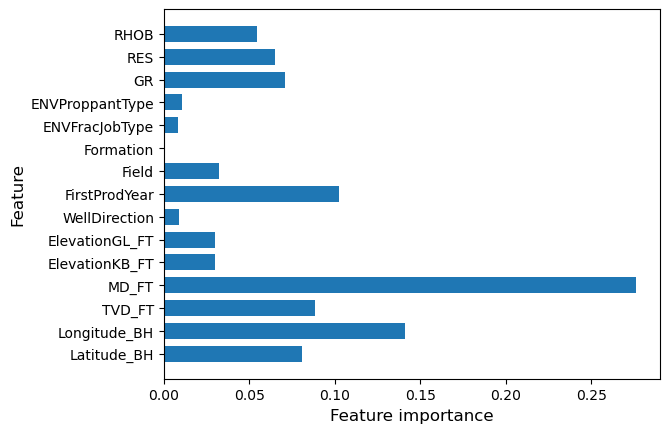

<Figure size 1500x1500 with 0 Axes>

In [12]:
RF_gas_best.steps[1][1].feature_importances_

plt.barh(X_data.columns, RF_gas_best.steps[1][1].feature_importances_, align='center', height=0.7)
plt.xlabel('Feature importance', size=12)
plt.ylabel('Feature', size=12)
plt.figure(figsize=(15,15))

RF_FI_ = pd.DataFrame(RF_gas_best.steps[1][1].feature_importances_)
RF_FI_.to_csv('RF_FI_Marcellus_WD_KrigingScenario1.csv') # 변수 중요도를 csv파일로 내보내기

In [13]:
Y_train_gas_ = pd.DataFrame(Y_train_gas)
Y_train_gas_.to_csv('Y_train_gas_RF_WLD_KrigingScenario1.csv')

Y_test_gas_ = pd.DataFrame(Y_test_gas)
Y_test_gas_.to_csv('Y_test_gas_RF_WLD_KrigingScenario1.csv')

Y_train_pred_gas = RF_gas_best.predict(X_train_gas)
Y_train_pred_gas_ = pd.DataFrame(Y_train_pred_gas)
Y_train_pred_gas_.to_csv('Y_train_pred_gas_RF_WLD_KrigingScenario1.csv')

Y_test_pred_gas = RF_gas_best.predict(X_test_gas)
Y_test_pred_gas_ = pd.DataFrame(Y_test_pred_gas)
Y_test_pred_gas_.to_csv('Y_test_pred_gas_RF_WLD_KrigingScenario1.csv')

(0.9518, 0.8226, 351669, 1115962)

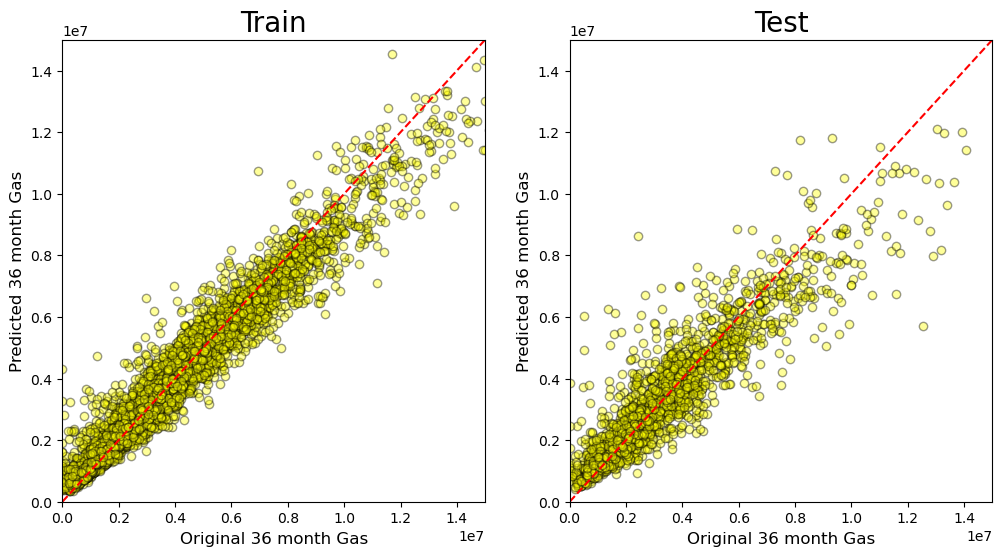

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(Y_train_gas, Y_train_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Train', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


plt.subplot(122)
plt.scatter(Y_test_gas, Y_test_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Test', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


(round(np.corrcoef(np.transpose(Y_train_gas), np.transpose(Y_train_pred_gas_))[0, 1]**2, 4),
round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2, 4),
round(mean_squared_error(Y_train_gas, Y_train_pred_gas_)/1000000),
round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000))

# LGBM

In [15]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

param_grid_lgbm = {
    "lgbm__num_leaves" : sp_randInt(20, 200),
    "lgbm__min_child_samples" : sp_randInt(20, 200),
    "lgbm__max_depth" : sp_randInt(20, 100),
    "lgbm__learning_rate" : [0.01, 0.05, 0.1, 0.2],
    "lgbm__reg_alpha" : [0, 0.01, 0.03],
    "lgbm__subsample" : [0.8, 0.9, 1],
}

#xgb_model = XGBRegressor()
#xgb_estimator = print_best_params(xgb_model, xgb_params)

In [16]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune

start = time.time()

LGBM_gas_pl = Pipeline([('scaler', RobustScaler()), ('lgbm', LGBMRegressor(objective='regression', bagging_seed=7, feature_fraction_seed=7,verbose=-1))])
LGBM_gas_best = HalvingRandomSearchCV(LGBM_gas_pl, param_grid_lgbm, random_state=222, scoring="neg_mean_squared_error", n_jobs=-1, n_candidates="exhaust", 
                                           factor=4).fit(X_train_gas, Y_train_gas).best_estimator_

Y_train_pred_gas_ = LGBM_gas_best.predict(X_train_gas).flatten()
Y_test_pred_gas_ = LGBM_gas_best.predict(X_test_gas).flatten()

score_lgbm_gas = mse_cv(LGBM_gas_best, X_train_gas, Y_train_gas)
print(round(score_lgbm_gas.mean()), "\t", round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000)) #, score)

r2_score_lgbm_gas = r2_score_cv(LGBM_gas_best, X_train_gas, Y_train_gas)
print("{:.4f}".format(r2_score_lgbm_gas.mean()), round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2,4))

# Fitting 4 folds for each of 200 candidates, totalling 800 fits
# 348.64857602119446

1249185 	 1176757
0.8095 0.8088
Wall time: 37.2 s


In [17]:
Y_train_gas_ = pd.DataFrame(Y_train_gas)
Y_train_gas_.to_csv('Y_train_gas_LGBM_WLD_KrigingScenario1.csv')

Y_test_gas_ = pd.DataFrame(Y_test_gas)
Y_test_gas_.to_csv('Y_test_gas_LGBM_WLD_KrigingScenario1.csv')

Y_train_pred_gas = LGBM_gas_best.predict(X_train_gas)
Y_train_pred_gas_ = pd.DataFrame(Y_train_pred_gas)
Y_train_pred_gas_.to_csv('Y_train_pred_gas_LGBM_WLD_KrigingScenario1.csv')

Y_test_pred_gas = LGBM_gas_best.predict(X_test_gas)
Y_test_pred_gas_ = pd.DataFrame(Y_test_pred_gas)
Y_test_pred_gas_.to_csv('Y_test_pred_gas_LGBM_WLD_KrigingScenario1.csv')

(0.8974, 0.8088, 680454, 1176757)

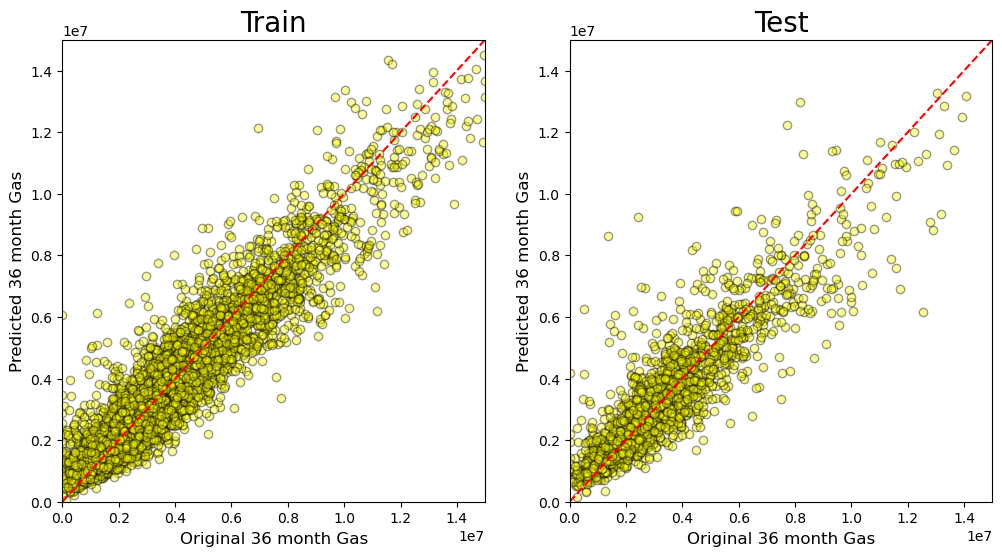

In [18]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(Y_train_gas, Y_train_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Train', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


plt.subplot(122)
plt.scatter(Y_test_gas, Y_test_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Test', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


(round(np.corrcoef(np.transpose(Y_train_gas), np.transpose(Y_train_pred_gas_))[0, 1]**2, 4),
round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2, 4),
round(mean_squared_error(Y_train_gas, Y_train_pred_gas_)/1000000),
round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000))

# (0.9437, 0.7576, 41383.0, 170695.0)

# Gradientboost

In [19]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import GradientBoostingRegressor

param_grid_gbr = {
        "gbr__learning_rate": sp_randFloat(),
        "gbr__subsample"    : sp_randFloat(),
        "gbr__n_estimators" : sp_randInt(100, 1000),
        "gbr__max_depth"    : sp_randInt(4, 10)
    }

In [20]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune

start = time.time()

GBR_gas_pl = Pipeline([('scaler', RobustScaler()), ('gbr', GradientBoostingRegressor(max_features='sqrt', loss='huber', random_state =42))])
GBR_gas_best = HalvingRandomSearchCV(GBR_gas_pl, param_grid_gbr, random_state=222, scoring="neg_mean_squared_error", n_jobs=-1, n_candidates="exhaust", 
                                           factor=4).fit(X_train_gas, Y_train_gas).best_estimator_

Y_train_pred_gas_ = GBR_gas_best.predict(X_train_gas).flatten()
Y_test_pred_gas_ = GBR_gas_best.predict(X_test_gas).flatten()

score_gbr_gas = mse_cv(GBR_gas_best, X_train_gas, Y_train_gas)
print(round(score_gbr_gas.mean()), "\t", round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000)) #, score)

r2_score_gbr_gas = r2_score_cv(GBR_gas_best, X_train_gas, Y_train_gas)
print("{:.4f}".format(r2_score_gbr_gas.mean()), round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2,4))

# Fitting 4 folds for each of 200 candidates, totalling 800 fits
# 348.64857602119446

1248939 	 1208560
0.8096 0.8055
Wall time: 5min 22s


In [21]:
Y_train_gas_ = pd.DataFrame(Y_train_gas)
Y_train_gas_.to_csv('Y_train_gas_GBR_WLD_KrigingScenario1.csv')

Y_test_gas_ = pd.DataFrame(Y_test_gas)
Y_test_gas_.to_csv('Y_test_gas_GBR_WLD_KrigingScenario1.csv')

Y_train_pred_gas = GBR_gas_best.predict(X_train_gas)
Y_train_pred_gas_ = pd.DataFrame(Y_train_pred_gas)
Y_train_pred_gas_.to_csv('Y_train_pred_gas_GBR_WLD_KrigingScenario1.csv')

Y_test_pred_gas = GBR_gas_best.predict(X_test_gas)
Y_test_pred_gas_ = pd.DataFrame(Y_test_pred_gas)
Y_test_pred_gas_.to_csv('Y_test_pred_gas_GBR_WLD_KrigingScenario1.csv')

(0.8829, 0.8055, 786816, 1208560)

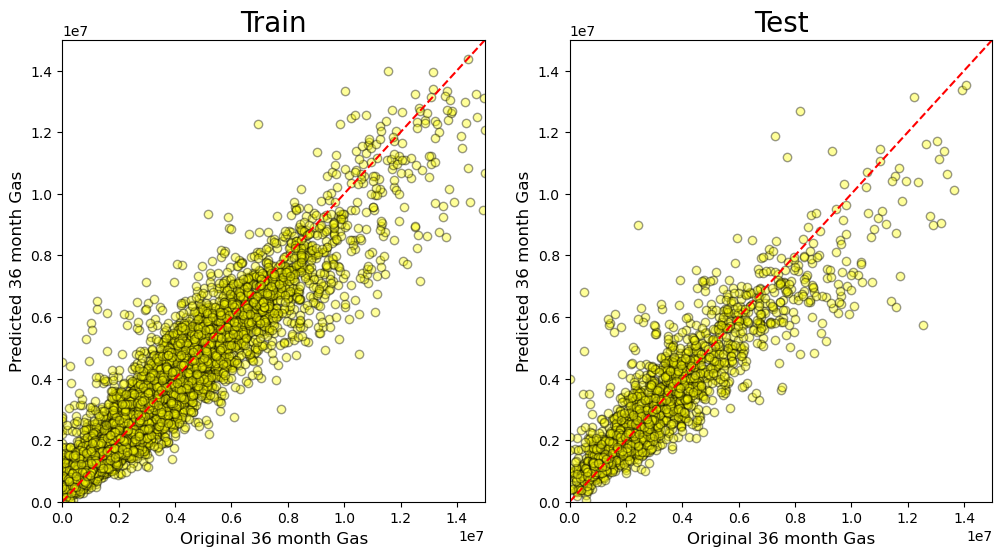

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(Y_train_gas, Y_train_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Train', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


plt.subplot(122)
plt.scatter(Y_test_gas, Y_test_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Test', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


(round(np.corrcoef(np.transpose(Y_train_gas), np.transpose(Y_train_pred_gas_))[0, 1]**2, 4),
round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2, 4),
round(mean_squared_error(Y_train_gas, Y_train_pred_gas_)/1000000),
round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000))

# XGBoost

In [23]:
from xgboost import XGBRegressor

param_grid_xgb = {
        "xgb__max_depth": [3, 4, 5],
        "xgb__gamma": [5, 30, 50],
        "xgb__learning_rate": [0.01, 0.1, 0.3, 0.5],
        "xgb__min_child_weight": [1, 3, 5],
        "xgb__reg_lambda": [50, 100, 300],
        "xgb__scale_pos_weight": [0.5, 1, 2],  # Fix scale_pos_weight
        "xgb__subsample": [0.7, 0.8, 0.9],
        "xgb__colsample_bytree": [0.7, 0.8, 0.9],
    }

In [24]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune

start = time.time()

XGB_gas_pl = Pipeline([('scaler', RobustScaler()), ('xgb', XGBRegressor(objective='reg:squarederror', seed=27)) ]) 
XGB_gas_best = HalvingRandomSearchCV(XGB_gas_pl, param_grid_xgb, random_state=222, scoring="neg_mean_squared_error", n_jobs=-1, n_candidates="exhaust", 
                                           factor=4).fit(X_train_gas, Y_train_gas).best_estimator_

Y_train_pred_gas_ = XGB_gas_best.predict(X_train_gas).flatten()
Y_test_pred_gas_ = XGB_gas_best.predict(X_test_gas).flatten()

score_xgb_gas = mse_cv(XGB_gas_best, X_train_gas, Y_train_gas)
print(round(score_xgb_gas.mean()), "\t", round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000)) #, score)

r2_score_xgb_gas = r2_score_cv(XGB_gas_best, X_train_gas, Y_train_gas)
print("{:.4f}".format(r2_score_xgb_gas.mean()), round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2,4))

# Fitting 4 folds for each of 200 candidates, totalling 800 fits
# 348.64857602119446

1368437 	 1273571
0.7913 0.793
Wall time: 19.7 s


In [25]:
Y_train_gas_ = pd.DataFrame(Y_train_gas)
Y_train_gas_.to_csv('Y_train_gas_XGB_WLD_KrigingScenario1.csv')

Y_test_gas_ = pd.DataFrame(Y_test_gas)
Y_test_gas_.to_csv('Y_test_gas_XGB_WLD_KrigingScenario1.csv')

Y_train_pred_gas = XGB_gas_best.predict(X_train_gas)
Y_train_pred_gas_ = pd.DataFrame(Y_train_pred_gas)
Y_train_pred_gas_.to_csv('Y_train_pred_gas_XGB_WLD_KrigingScenario1.csv')

Y_test_pred_gas = XGB_gas_best.predict(X_test_gas)
Y_test_pred_gas_ = pd.DataFrame(Y_test_pred_gas)
Y_test_pred_gas_.to_csv('Y_test_pred_gas_XGB_WLD_KrigingScenario1.csv')

(0.856, 0.793, 946720, 1273571)

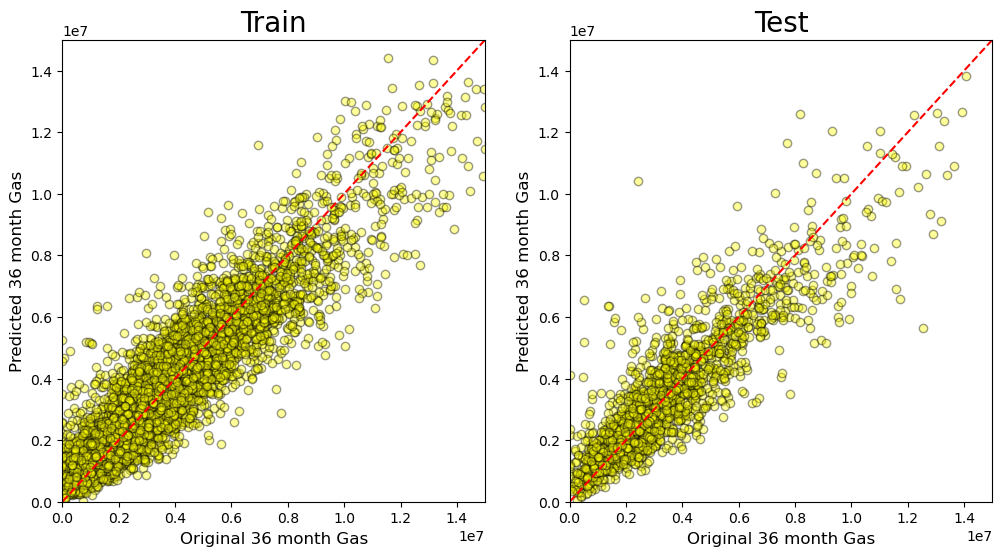

In [26]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(Y_train_gas, Y_train_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Train', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


plt.subplot(122)
plt.scatter(Y_test_gas, Y_test_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Test', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


(round(np.corrcoef(np.transpose(Y_train_gas), np.transpose(Y_train_pred_gas_))[0, 1]**2, 4),
round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2, 4),
round(mean_squared_error(Y_train_gas, Y_train_pred_gas_)/1000000),
round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000))

# Ensemble 2

In [27]:
from sklearn.ensemble import VotingRegressor

r1 = RF_gas_best
r2 = LGBM_gas_best
r3 = GBR_gas_best
r4 = XGB_gas_best

er = VotingRegressor([('rf', r1), ('lgbm', r2), ('gbr', r3), ('xgb', r4)])
er.fit(X_train_gas, Y_train_gas)


VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('scaler', RobustScaler()),
                                             ('rf',
                                              RandomForestRegressor(max_depth=86,
                                                                    max_features='sqrt',
                                                                    min_samples_leaf=2,
                                                                    n_estimators=6523,
                                                                    random_state=42))])),
                            ('lgbm',
                             Pipeline(steps=[('scaler', RobustScaler()),
                                             ('lgbm',
                                              LGBMRegressor(bagging_seed=7,
                                                            feature_fraction_seed=7,
                                                            max_depth=55,
     

In [28]:
%%time
Y_train_pred_gas_ = er.predict(X_train_gas).flatten()
Y_test_pred_gas_ = er.predict(X_test_gas).flatten()

score_er_gas = mse_cv(er, X_train_gas, Y_train_gas)
print(round(score_er_gas.mean()), "\t", round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000)) #, score)

r2_score_er_gas = r2_score_cv(er, X_train_gas, Y_train_gas)
print("{:.4f}".format(r2_score_er_gas.mean()), "\t", round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2,4))

1194720 	 1129363
0.8179 	 0.818
Wall time: 10min 31s


In [29]:
Y_train_gas_ = pd.DataFrame(Y_train_gas)
Y_train_gas_.to_csv('Y_train_gas_ES_WLD_KrigingScenario1.csv')

Y_test_gas_ = pd.DataFrame(Y_test_gas)
Y_test_gas_.to_csv('Y_test_gas_ES_WLD_KrigingScenario1.csv')

Y_train_pred_gas = er.predict(X_train_gas)
Y_train_pred_gas_ = pd.DataFrame(Y_train_pred_gas)
Y_train_pred_gas_.to_csv('Y_train_pred_gas_ES_WLD_KrigingScenario1.csv')

Y_test_pred_gas = er.predict(X_test_gas)
Y_test_pred_gas_ = pd.DataFrame(Y_test_pred_gas)
Y_test_pred_gas_.to_csv('Y_test_pred_gas_ES_WLD_KrigingScenario1.csv')

(0.9077, 0.818, 627341, 1129363)

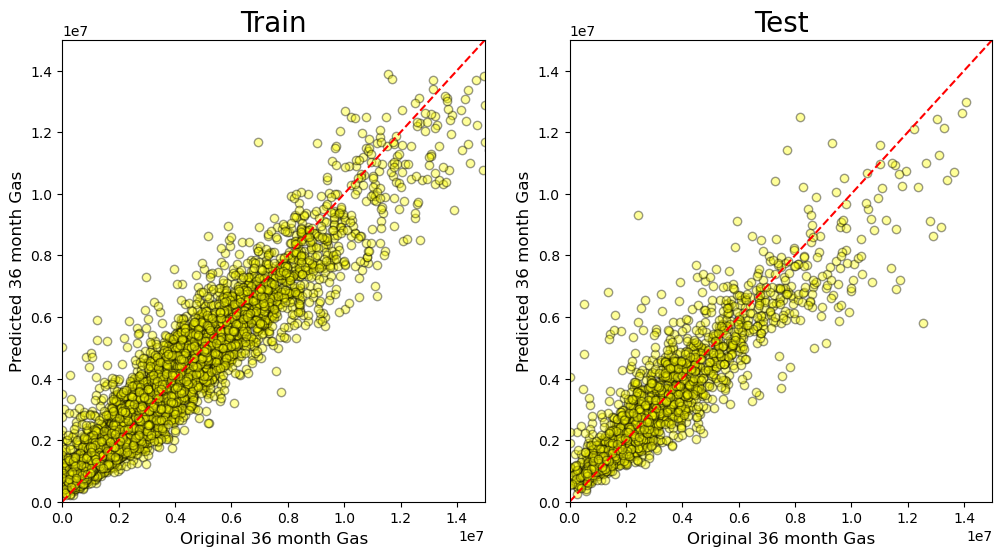

In [30]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(Y_train_gas, Y_train_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Train', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


plt.subplot(122)
plt.scatter(Y_test_gas, Y_test_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Test', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


(round(np.corrcoef(np.transpose(Y_train_gas), np.transpose(Y_train_pred_gas_))[0, 1]**2, 4),
round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2, 4),
round(mean_squared_error(Y_train_gas, Y_train_pred_gas_)/1000000),
round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000))

# Voting Weights

In [31]:
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler

voting_weights = softmax(1/(StandardScaler().fit_transform(np.array([score_rf_gas.mean(), score_lgbm_gas.mean(), 
                                                                     score_gbr_gas.mean(), score_xgb_gas.mean()]).reshape(-1,1))+3)).flatten()
print("\nVoting Weights\t\t:", voting_weights)



Voting Weights		: [0.29855709 0.24417798 0.24428989 0.21297504]


In [32]:
er_vw_gas = VotingRegressor([('rf', r1), ('lgbm', r2), ('gbr', r3), ('xgb', r4)], weights = voting_weights.flatten()) #, ('xgb', r4)])
er_vw_gas.fit(X_train_gas, Y_train_gas)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('scaler', RobustScaler()),
                                             ('rf',
                                              RandomForestRegressor(max_depth=86,
                                                                    max_features='sqrt',
                                                                    min_samples_leaf=2,
                                                                    n_estimators=6523,
                                                                    random_state=42))])),
                            ('lgbm',
                             Pipeline(steps=[('scaler', RobustScaler()),
                                             ('lgbm',
                                              LGBMRegressor(bagging_seed=7,
                                                            feature_fraction_seed=7,
                                                            max_depth=55,
     

In [33]:
%%time
Y_train_pred_gas_ = er_vw_gas.predict(X_train_gas).flatten()
Y_test_pred_gas_ =er_vw_gas.predict(X_test_gas).flatten()

score_er_vw_gas = mse_cv(er_vw_gas, X_train_gas, Y_train_gas)
print(round(score_er_vw_gas.mean()), "\t", round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000)) #, score)

r2_score_er_vw_gas = r2_score_cv(er_vw_gas, X_train_gas, Y_train_gas)
print("{:.4f}".format(r2_score_er_vw_gas.mean()), "\t", round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2,4))


1187269 	 1122928
0.8190 	 0.8193
Wall time: 11min 20s


In [34]:
Y_train_gas_ = pd.DataFrame(Y_train_gas)
Y_train_gas_.to_csv('Y_train_gas_ES_VW_WLD_KrigingScenario1.csv')

Y_test_gas_ = pd.DataFrame(Y_test_gas)
Y_test_gas_.to_csv('Y_test_gas_ES_VW_WLD_KrigingScenario1.csv')

Y_train_pred_gas = er_vw_gas.predict(X_train_gas)
Y_train_pred_gas_ = pd.DataFrame(Y_train_pred_gas)
Y_train_pred_gas_.to_csv('Y_train_pred_gas_ES_VW_WLD_KrigingScenario1.csv')

Y_test_pred_gas = er_vw_gas.predict(X_test_gas)
Y_test_pred_gas_ = pd.DataFrame(Y_test_pred_gas)
Y_test_pred_gas_.to_csv('Y_test_pred_gas_ES_VW_WLD_KrigingScenario1.csv')

(0.9121, 0.8193, 600075, 1122928)

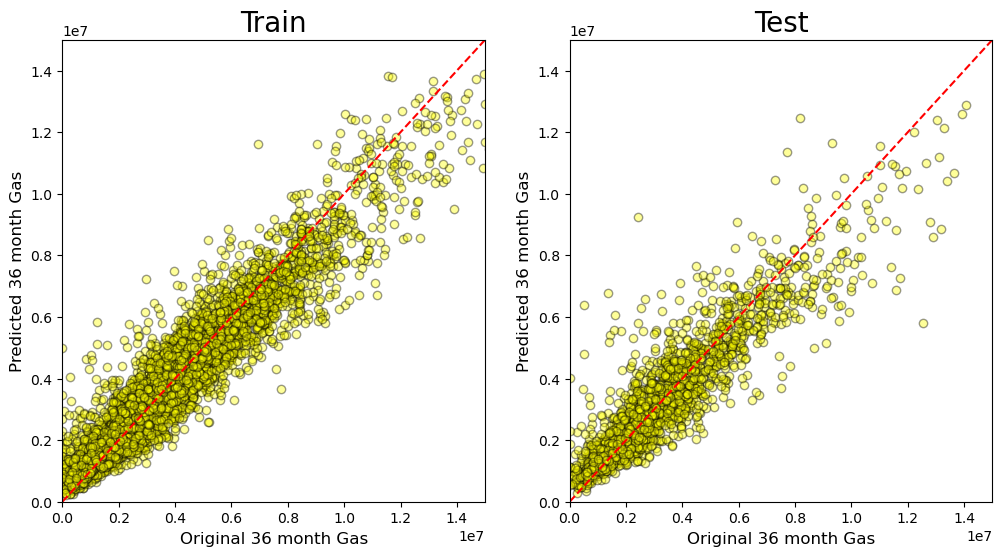

In [35]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(Y_train_gas, Y_train_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Train', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


plt.subplot(122)
plt.scatter(Y_test_gas, Y_test_pred_gas_, alpha=0.4, facecolors='yellow', edgecolors='black', linewidth=1)
plt.xlabel('Original 36 month Gas', size=12)
plt.ylabel('Predicted 36 month Gas', size=12)
plt.title('Test', size=20)
plt.xlim([0, 15e6])
plt.ylim([0, 15e6])
t=np.arange(0, 15e6, 1)
plt.plot(t,t,'r--')


(round(np.corrcoef(np.transpose(Y_train_gas), np.transpose(Y_train_pred_gas_))[0, 1]**2, 4),
round(np.corrcoef(np.transpose(Y_test_gas), np.transpose(Y_test_pred_gas_))[0, 1]**2, 4),
round(mean_squared_error(Y_train_gas, Y_train_pred_gas_)/1000000),
round(mean_squared_error(Y_test_gas, Y_test_pred_gas_)/1000000))